In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score

# Load the dataset
df = pd.read_excel('retail_data.xlsx') 
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [20]:
# Handle missing values
df = df.dropna(subset=['CustomerID'])  # Drop rows with missing CustomerID

# Remove cancellations (negative quantities)
df = df[df['Quantity'] > 0]

# Calculate total spending per transaction
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

# Aggregate data by CustomerID for clustering
customer_data = df.groupby('CustomerID').agg({
    'TotalPrice': 'sum',      # Total spending
    'Quantity': 'sum',        # Total items purchased
    'InvoiceNo': 'nunique'    # Number of transactions
}).rename(columns={'InvoiceNo': 'NumTransactions'})

# Log transform to reduce skewness (adding 1 to avoid log(0))
customer_data[['TotalPrice', 'Quantity']] = np.log1p(customer_data[['TotalPrice', 'Quantity']])

# Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(customer_data)

print("Preprocessed Data Shape:", X_scaled.shape)
customer_data.head()

Preprocessed Data Shape: (4339, 3)


,TotalPrice,Quantity,NumTransactions
CustomerID,,,
12346.0,11.253955,11.214735,1
12347.0,8.368925,7.807510,7
12348.0,7.494564,7.758761,4
12349.0,7.472245,6.448889,1
12350.0,5.815324,5.288267,1


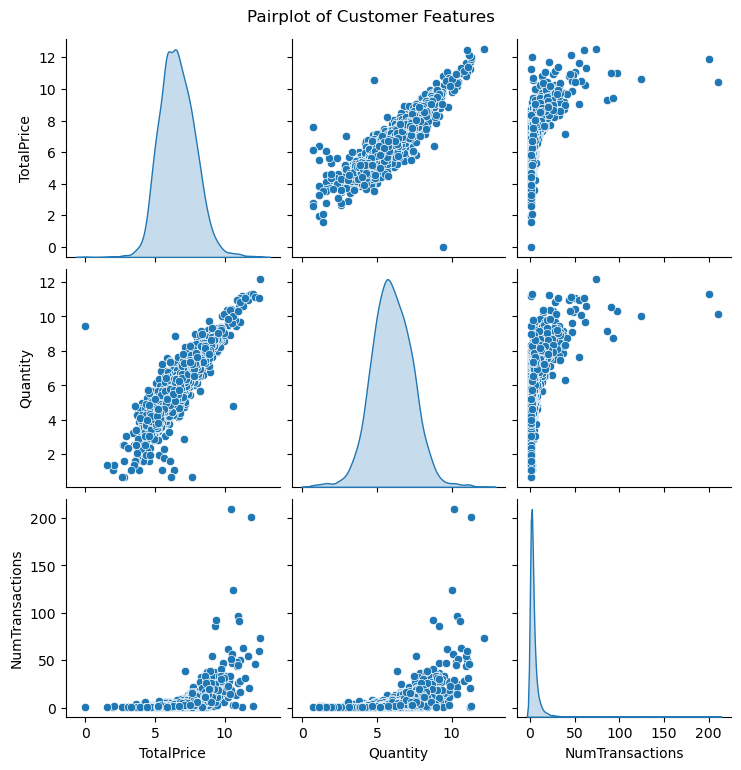

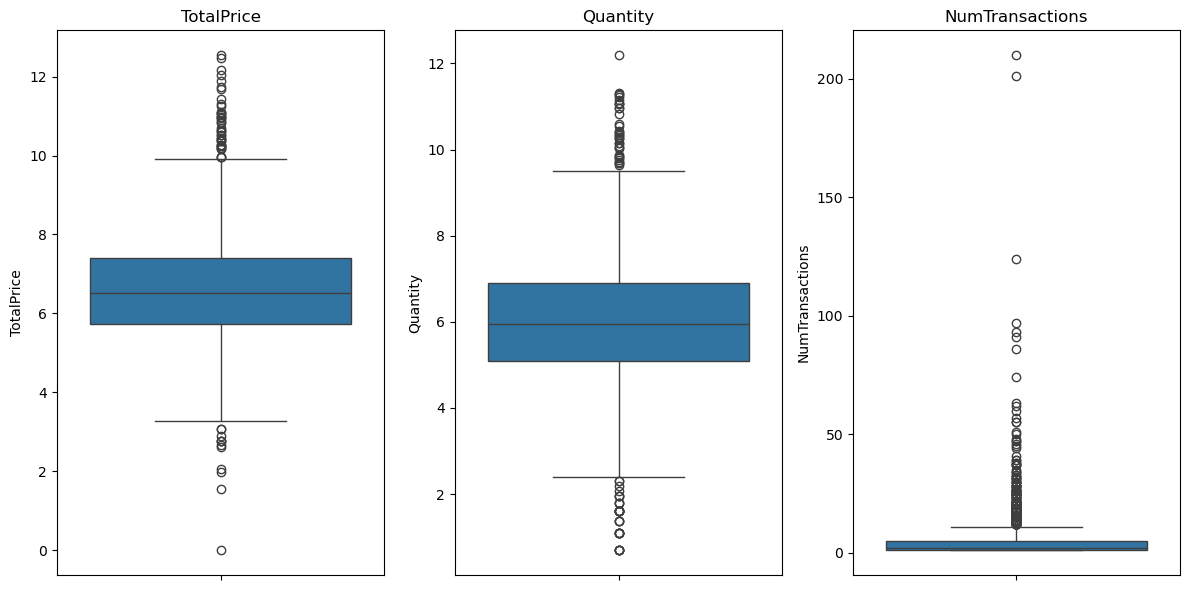

In [22]:
# Pairplot of features
sns.pairplot(customer_data, diag_kind='kde')
plt.suptitle("Pairplot of Customer Features", y=1.02)
plt.show()

# Boxplot of features
plt.figure(figsize=(12, 6))
for i, col in enumerate(customer_data.columns):
    plt.subplot(1, 3, i+1)
    sns.boxplot(y=customer_data[col])
    plt.title(col)
plt.tight_layout()
plt.show()

**Insights**: 
- The pairplot shows relationships between total spending, quantity, and number of transactions. TotalPrice and Quantity are likely correlated due to their multiplicative nature.
- Boxplots reveal outliers, justifying the log transformation to normalize distributions.

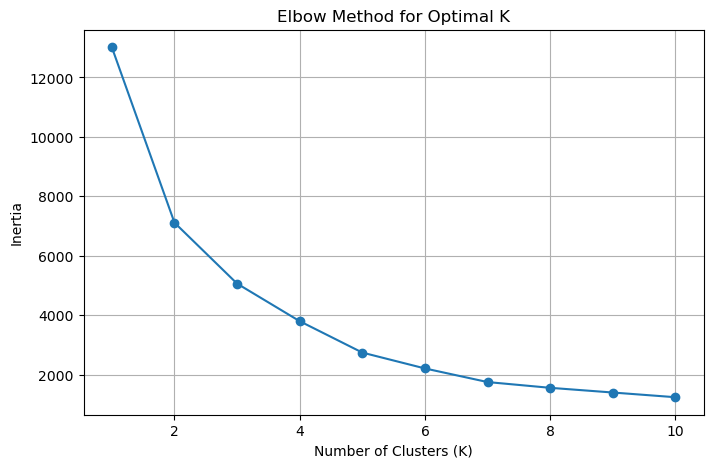

In [24]:
# Elbow method to determine optimal K
inertia = []
K_range = range(1, 11)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# Plot elbow curve
plt.figure(figsize=(8, 5))
plt.plot(K_range, inertia, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.grid(True)
plt.show()

**Insights**: The elbow point (where inertia starts to flatten) suggests the optimal K (e.g., 3 or 4, depending on the curve). We'll proceed with K=3 for this example.

Cluster Summary:
          TotalPrice   Quantity  NumTransactions
Cluster                                        
0          5.754411   5.094466         1.719604
1          7.720393   7.192450         6.968750
2         10.832794  10.250439        77.545455


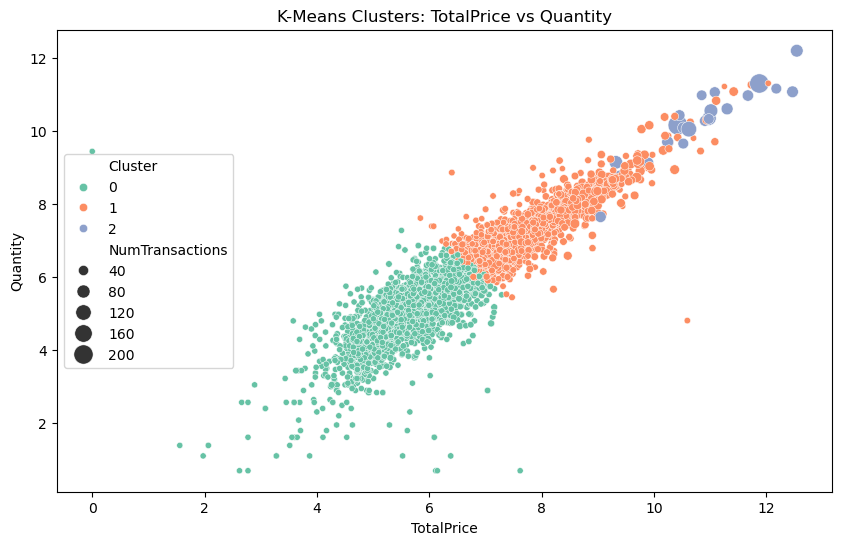

In [26]:
# Apply K-Means with optimal K (e.g., 3)
kmeans = KMeans(n_clusters=3, random_state=42)
customer_data['Cluster'] = kmeans.fit_predict(X_scaled)

# Analyze clusters
cluster_summary = customer_data.groupby('Cluster').mean()
print("Cluster Summary:\n", cluster_summary)

# Visualize clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x='TotalPrice', y='Quantity', hue='Cluster', size='NumTransactions', 
                data=customer_data, palette='Set2', sizes=(20, 200))
plt.title('K-Means Clusters: TotalPrice vs Quantity')
plt.show()

**Insights**: 
- Clusters likely represent low, medium, and high spenders based on TotalPrice and Quantity.
- NumTransactions as size shows transaction frequency differences across clusters.